# Simulated data comparison of feature elimination

In [2]:
import os,errno
import numpy as np
import pandas as pd
from time import time
from plotnine import *
from scripts import raffe
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import normalized_mutual_info_score as nmi

/usr/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)
        

def mkdir_p(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

## Classification example

In [4]:
# make output directory
outdir = 'classification_simu/'
mkdir_p(outdir)

# Create a dataset with only 10 informative features
X, y = make_classification(
    n_samples=500, n_features=10000, n_informative=100, n_redundant=250,
    n_repeated=0, n_classes=2, n_clusters_per_class=1, random_state=13
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cla = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

### RFE

/usr/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


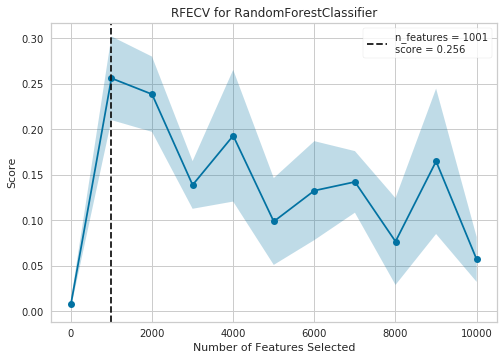

Runtime of the program is 183.57502031326294


In [5]:
# Instantiate RFECV visualizer with a random forest classifier
start = time()
visualizer = RFECV(cla, cv=cv, step=0.1, n_jobs=-1, 
                   scoring="normalized_mutual_info_score")
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show(outpath="%s/rfecv_classification_nmi.pdf" % outdir)
visualizer.show(outpath="%s/rfecv_classification_nmi.png" % outdir)
visualizer.show()           # Finalize and render the figure
end = time()
print(f"Runtime of the program is {end - start}")

In [6]:
## Instantiate RFECV visualizer with a random forest classifier
#start = time()
#visualizer = RFECV(cla, cv=cv, step=100, n_jobs=-1) # step function does not decay
#visualizer.fit(X, y)        # Fit the data to the visualizer
#visualizer.show(outpath="%s/rfecv_classification_score_100step.pdf" % outdir)
#visualizer.show(outpath="%s/rfecv_classification_score_100step.png" % outdir)
#visualizer.show()           # Finalize and render the figure
#end = time()
#print(f"Runtime of the program is {end - start}")

### RaFFE

#### Optimize regression

In [7]:
fold = 1
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fold += 1
fold -= 1

features = ["feature_%d" % x for x in range(X_train.shape[1])]
d, pfirst = raffe.feature_elimination(cla, X_train, y_train, 
                                      np.array(features), 
                                      fold, outdir, 
                                      elimination_rate=0.1, 
                                      RANK=False)

for frac in [0.3, 0.35, 0.4]:
    raffe.optimize_lowess_plot(d, fold, outdir, frac=frac, step_size=0.05, 
                               classify=True, save_plot=False)

In [20]:
print(raffe.extract_max_lowess(d, frac=0.35))
raffe.extract_redundant_lowess(d, frac=0.35)

(104, 4.6491870714048655)


(274, 5.614951260949585)

#### Function to run RaFFE

In [22]:
def run_raffe_cla(estimator, x_train, x_test, y_train, y_test, fold, outdir):
    features = ["feature_%d" % x for x in range(x_train.shape[1])]
    d, pfirst = raffe.feature_elimination(estimator, x_train, y_train, 
                                          np.array(features), 
                                          fold, outdir, 
                                          elimination_rate=0.1, 
                                          RANK=True)
    df_elim = pd.DataFrame([{'fold':fold,
                             'n features':k,
                             'normalized mutual information':d[k][1], 
                             'accuracy':d[k][2], 
                             'ROC AUC':d[k][3]} for k in d.keys()])
    n_features_max = max(d, key=lambda x: d[x][1])
    try:
        n_features,_ = raffe.extract_max_lowess(d, frac=0.35)
        n_redundant,_ = raffe.extract_redundant_lowess(d, frac=0.35)
        raffe.plot_with_lowess_vline(d, fold, outdir,
                                     classify=True)
        raffe.optimize_lowess_plot(d, fold, outdir, frac=0.35, step_size=0.05, 
                                   classify=True, save_plot=True)
    except ValueError:
        n_features = n_features_max 
    estimator.fit(x_train[:,d[n_features][4]], y_train)
    labels_pred = estimator.predict(x_test[:, d[n_features][4]])
    metrics_df = pd.DataFrame({'n_features_max': n_features_max, 
                               'n_features': n_features, 
                               'n_redundant': n_redundant,
                               'train_acc':raffe.oob_score_accuracy(estimator, y_train), 
                               'train_nmi':raffe.oob_score_nmi(estimator, y_train),
                               'train_roc':raffe.oob_score_roc(estimator, y_train), 
                               'test_acc':accuracy_score(y_test, labels_pred), 
                               'test_nmi':nmi(y_test, labels_pred,
                                              average_method='arithmetic'), 
                               'test_roc':roc_auc_score(y_test, labels_pred)}, 
                              index=[fold])
    return df_elim, metrics_df

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


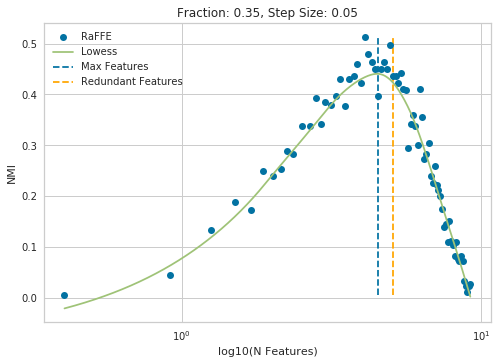

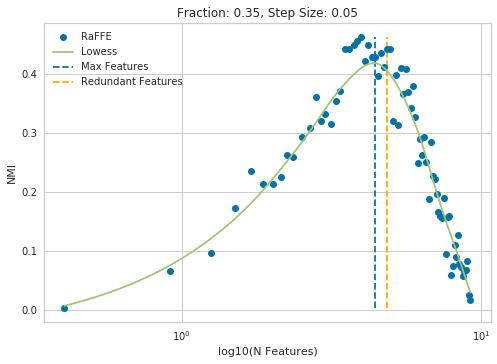

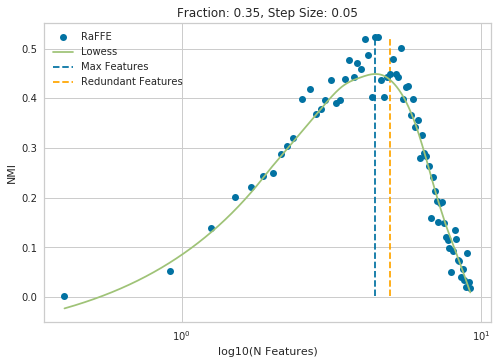

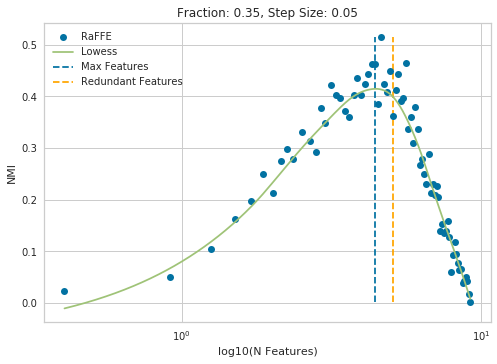

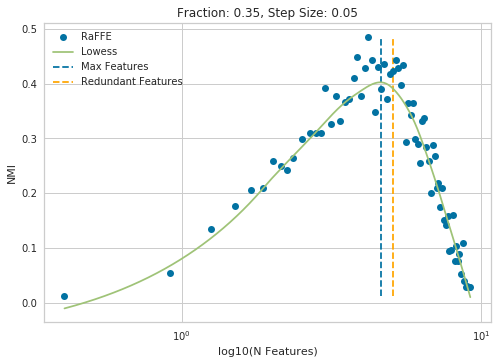

Runtime of the program is 229.25718665122986


In [23]:
start = time()
df_dict = pd.DataFrame()
output = pd.DataFrame()
fold = 1
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    df_elim, metrics_df = run_raffe_cla(cla, X_train, X_test, y_train, 
                                        y_test, fold, outdir)
    df_dict = pd.concat([df_dict, df_elim], axis=0)
    output = pd.concat([output, metrics_df.reset_index()], axis=0)
    fold += 1
end = time()
print(f"Runtime of the program is {end - start}")

In [26]:
li = output.set_index('index').loc[:, 'n_features'].mean()
lo = output.set_index('index').loc[:, 'n_features_max'].mean()
output.set_index('index').median()

n_features_max     66.000000
n_features         83.000000
n_redundant       160.000000
train_acc           0.867500
train_nmi           0.436404
train_roc           0.867559
test_acc            0.830000
test_nmi            0.342568
test_roc            0.830000
dtype: float64

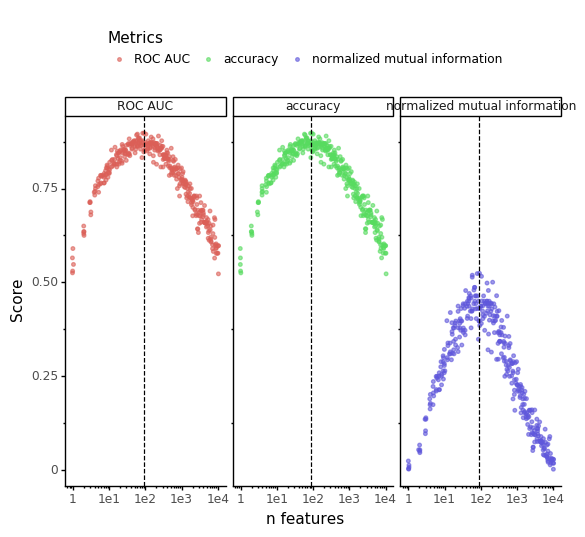

<ggplot: (8777455166919)>

In [25]:
dft = pd.melt(df_dict, id_vars=['fold', 'n features'], 
              value_vars=['normalized mutual information', 'accuracy', 'ROC AUC'],
              var_name='Metrics', value_name='Score')

gg = ggplot(dft, aes(x='n features', y='Score', color='Metrics')) +\
    geom_jitter(size=1, alpha=0.6) + facet_wrap('~Metrics') +\
    geom_vline(xintercept=li, color='black', linetype='dashed') +\
    scale_x_log10() + theme_classic() + theme(legend_position="top")
save_plot(gg, '%s/raffe_feature_selection' % outdir, 12, 4)
gg

## Regression example

In [27]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evar

In [33]:
# make output directory
outdir = 'regression_simu/'
mkdir_p(outdir)

# Create a dataset with only 10 informative features
X, y = make_regression(
    n_samples=500, n_features=10000, n_informative=100, bias=0.2,
    n_targets=1, noise=20, random_state=13
)

cv = KFold(n_splits=5, shuffle=True, random_state=13)
regr = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)

### RFE

/usr/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


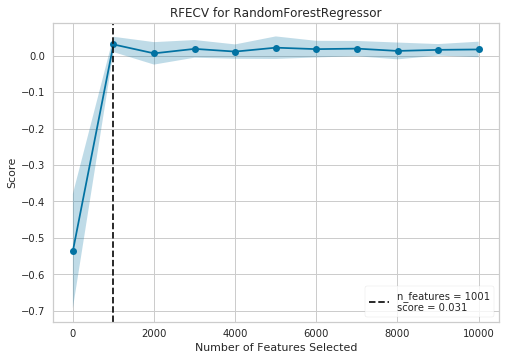

Runtime of the program is 3126.779906988144


In [34]:
# Instantiate RFECV visualizer with a random forest classifier
start = time()
visualizer = RFECV(regr, cv=cv, step=0.1, n_jobs=-1)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show(outpath="%s/rfecv_regression.png" % outdir)
visualizer.show(outpath="%s/rfecv_regression.pdf" % outdir)
visualizer.show()           # Finalize and render the figure
end = time()
print(f"Runtime of the program is {end - start}")

In [35]:
## Instantiate RFECV visualizer with a random forest classifier
#start = time()
#visualizer = RFECV(regr, cv=cv, step=10, n_jobs=-1)
#visualizer.fit(X, y)        # Fit the data to the visualizer
#visualizer.show(outpath="%s/rfecv_regression_5step.png" % outdir)
#visualizer.show(outpath="%s/rfecv_regression_5step.pdf" % outdir)
#visualizer.show()           # Finalize and render the figure
#end = time()
#print(f"Runtime of the program is {end - start}")

### RaFFE

#### Optimize regression

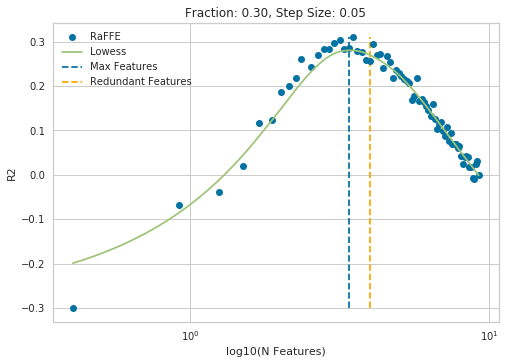

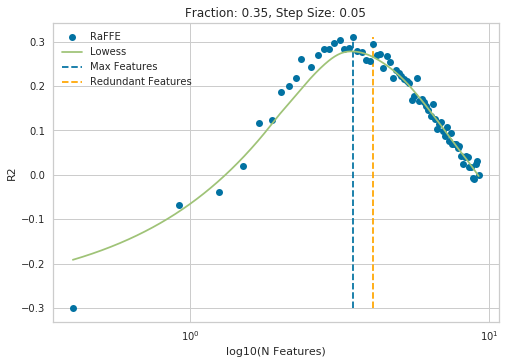

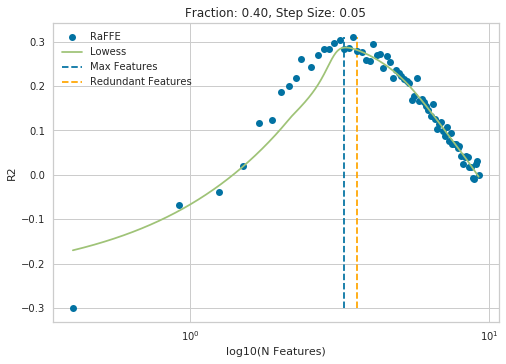

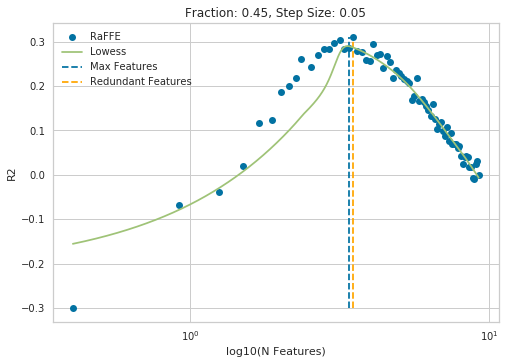

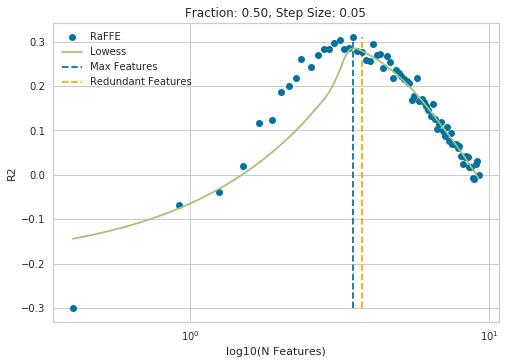

In [36]:
fold = 1
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fold += 1
fold -= 1

features = ["feature_%d" % x for x in range(X_train.shape[1])]
d, pfirst = raffe.feature_elimination(regr, X_train, y_train, 
                                      np.array(features), 
                                      fold, outdir, 
                                      elimination_rate=0.1, 
                                      RANK=False)

for frac in [0.3, 0.35, 0.4, 0.45, 0.5]:
    raffe.optimize_lowess_plot(d, fold, outdir, frac=frac, step_size=0.05, 
                               classify=False, save_plot=False)

In [38]:
print(raffe.extract_max_lowess(d, frac=0.30))
raffe.extract_redundant_lowess(d, frac=0.30)

(33, 3.5115454388310208)


(59, 4.085976312551584)

#### Run RaFFE function

In [ ]:
def run_raffe_regr(estimator, x_train, x_test, y_train, y_test, fold, outdir):
    features = ["feature_%d" % x for x in range(x_train.shape[1])]
    d, pfirst = raffe.feature_elimination(estimator, x_train, y_train, 
                                          np.array(features), 
                                          fold, outdir, 
                                          elimination_rate=0.1, 
                                          RANK=True)
    df_elim = pd.DataFrame([{'fold':fold,
                             'n features':k,
                             'R2':d[k][1], 
                             'Mean Square Error':d[k][2], 
                             'Explained Variance':d[k][3]} for k in d.keys()])
    n_features_max = max(d, key=lambda x: d[x][1])
    try:
        n_features,_ = raffe.extract_max_lowess(d)
        n_redundant,_ = raffe.extract_redundant_lowess(d)
        raffe.plot_with_lowess_vline(d, fold, outdir,
                                     classify=False)
        raffe.optimize_lowess_plot(d, fold, outdir, frac=3/10, step_size=0.05, 
                                   classify=False, save_plot=True)
    except ValueError:
        n_features = n_features_max 
    estimator.fit(x_train[:,d[n_features][4]], y_train)
    labels_pred = estimator.predict(x_test[:, d[n_features][4]])
    metrics_df = pd.DataFrame({'n_features_max': n_features_max, 
                               'n_features': n_features, 
                               'n_redundant': n_redundant,
                               'train_r2':raffe.oob_score_r2(estimator, y_train), 
                               'train_evar':raffe.oob_score_evar(estimator, y_train),
                               'train_mse':raffe.oob_score_mse(estimator, y_train), 
                               'test_r2':r2_score(y_test, labels_pred), 
                               'test_evar':evar(y_test, labels_pred,
                                                multioutput='uniform_average'), 
                               'test_mse':mean_squared_error(y_test, labels_pred)}, 
                              index=[fold])
    
    return df_elim, metrics_df

In [ ]:
start = time()
df_dict = pd.DataFrame()
output = pd.DataFrame()
fold = 1
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    df_elim, metrics_df = run_raffe_regr(regr, X_train, X_test, 
                                         y_train, y_test, fold, outdir)
    df_dict = pd.concat([df_dict, df_elim], axis=0)
    output = pd.concat([output, metrics_df.reset_index()], axis=0)
    fold += 1
end = time()
print(f"Runtime of the program is {end - start}")

In [ ]:
li = output.set_index('index').loc[:, 'n_features'].mean()
lo = output.set_index('index').loc[:, 'n_features_max'].mean()
output.set_index('index').mean()

In [ ]:
dft = pd.melt(df_dict, id_vars=['fold', 'n features'], 
              value_vars=['R2', 'Mean Square Error', 'Explained Variance'],
              var_name='Metrics', value_name='Score')

gg = ggplot(dft, aes(x='n features', y='Score', color='Metrics')) +\
    geom_jitter(size=1, alpha=0.6) + facet_wrap('~Metrics', scales='free') +\
    geom_vline(xintercept=li, color='black', linetype='dashed') +\
    scale_x_log10() + theme_classic() + theme(legend_position="top")
save_plot(gg, '%s/raffe_feature_selection' % outdir, 12, 4)
gg